In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install biom-format
%pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 85.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for biom-format: filename=biom_format-2.1.16-cp310-cp310-linux_x86_64.whl size=12158959 sha256=1c7a5e099edf28bfcafbee0b66aea63ee8ae3abc7804a3ab75d88fc5bdf64cb9
  Stored in directory: /root/.cache/pip/wheels/8e/a9/f9/197fd5a0e5bbab5f2e03c89194f6c194bed7af5d7a8c8759f3
Successfully built biom-format
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.8 MB/s eta 0:00:00


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
# %cd /content/drive/MyDrive/METNN
import preprocessing as prep
import MET
import UniFrac as UF
import biom
import numpy as np
from Bio import Phylo
import pandas as pd

/Users/calebchin/Documents/METNN/MET.py:119: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  C = 6 * d * M**2 (48*c1)**(k/2)


Approximate n by taking average number of sequence reads over all samples

In [13]:
def check_node_names(newick_file):
    """
    Checks if all nodes in a Newick tree have explicit names.

    Parameters:
    - newick_file (str): Path to the Newick file.

    Returns:
    - bool: True if all nodes have explicit names, False otherwise.
    """
    tree = Phylo.read(newick_file, "newick")
    
    # Traverse all nodes (clades) in the tree
    for clade in tree.find_clades():
        if clade.name is None:
            return False  # Found a node without a name
    return True

In [15]:
check_node_names("processed_data/tree.nwk")

False

In [10]:
import pandas as pd

seq_counts_df = pd.read_csv('seq_counts.tsv', sep='\t')
seq_counts_df = seq_counts_df.drop(seq_counts_df.index[0])
seq_counts_df["filtered"] = seq_counts_df["filtered"].astype(int)
n = (seq_counts_df["filtered"]).mean()
print(n)


31184.76


In [ ]:
def get_empirical_subset(table, selected_samples):
    """
    Computes the empirical distributions for a subset of samples given a biom feature table.

    Inputs:
    - table: a biom feature table
    - selected_samples: list of sample indices to process

    Returns:
    - empirical: a list of empirical distributions for the selected samples.
    """
    data_matrix = table.matrix_data.toarray()
    empirical = []

    for sample_index in selected_samples:
        sum_sample = np.sum(data_matrix[:, sample_index])
        sample_est = {}

        for species_index in range(len(data_matrix)):
            OTU = table.ids('observation')[species_index]
            sample_est[OTU] = (data_matrix[species_index][sample_index] / sum_sample)

        empirical.append(sample_est)

    return empirical




def empirical_dist_edge_len_subset(tree, table, selected_samples, selected_OTUs):
    """
    Returns a subset of the empirical distributions for selected edges (OTUs) and their lengths,
    based on a subset of selected samples.

    Inputs:
    - tree: Phylogenetic tree (in Newick format)
    - table: BIOM feature table
    - selected_samples: List of sample indices to process
    - selected_OTUs: List of OTU IDs (edges) to process

    Returns:
    - Ls: List of edge lengths for the selected OTUs
    - dists: List of empirical distributions for the selected edges (OTUs)
    """
    empirical_dist = get_empirical_subset(table, selected_samples)
    num_samples = len(empirical_dist)


    loaded_tree = Phylo.read(tree, "newick")

    # Initialize lists to store edge lengths and distributions
    Ls = []
    dists = [[] for _ in range(num_samples)]

    for node in loaded_tree.find_clades():
        if node.name in selected_OTUs:
            if node.branch_length is not None:
                Ls.append(node.branch_length)
                descendants = [node] + list(node.find_clades())
                for i in range(num_samples):
                    total = 0
                    for OTU in descendants:
                        if OTU.name in empirical_dist[i]:
                            total += empirical_dist[i][OTU.name]
                    dists[i].append(total)

    return Ls, dists

In [6]:
#Random -first two sample

table = biom.load_table('processed_data/feature-table.biom')


selected_samples = [0, 1]


empirical_dist_subset = prep.get_empirical_subset(table, selected_samples)


empirical_dist_subset


[{np.str_('668fdb718997fc1589c7817655d4bb5f'): np.float64(0.00016960171863074879),
  np.str_('a3f36ef32153f2fc2aaeac2feb23777f'): np.float64(0.013624671396670153),
  np.str_('9496d87b94d90dff068f0716603930bd'): np.float64(0.3378466235124516),
  np.str_('1b158b8b2922d4fcad5d9cea607cbb7d'): np.float64(0.04341803996947169),
  np.str_('23fed68c6c76ab10ba1be8a43e9176e7'): np.float64(0.0),
  np.str_('a7a1a93ecfcef4cb45b42307a4fa3bca'): np.float64(0.0),
  np.str_('c3bdda568b2c1580d5cce7407ef43909'): np.float64(0.003109364841563728),
  np.str_('b65eb19257f7a2bedb5a1c4b42aeb396'): np.float64(0.0),
  np.str_('6a6fcf8f9b8bb1ab9e5f8456ee7fb109'): np.float64(0.032139525680526894),
  np.str_('cc2d96099f530b503371e5ddca8c0a58'): np.float64(0.0008480085931537439),
  np.str_('7d285be20e3ad3812eb21be379357ef1'): np.float64(0.0),
  np.str_('25d727166a36df8d2f6a915a945bf5ac'): np.float64(0.04248523051700257),
  np.str_('51e441cbdcc80da0656e82293ae160b5'): np.float64(0.0010741442179947424),
  np.str_('e594

In [49]:
#list of otu id and sample id from table
ids = table.ids('observation')
sampleid = table.ids('sample')
#print(sampleid)



In [7]:

#first sample
selected_samples = [0, 1, 2, 3]
tree = Phylo.read('processed_data/tree.nwk', "newick")
tree = prep.assign_default_names(tree)
abun, lengths, edges = prep.get_distributions(tree, table, selected_samples)

print("Edge lengths:", lengths )
print("Edge distributions:", abun)

Edge lengths: [0.327872   0.172253   0.0195132  ... 0.00166077 0.028472   0.00925992]
Edge distributions: [array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]


In [9]:
np.sum(abun[0])

np.float64(74.82661050965318)

In [64]:
unifrac_data = np.load("UniFrac_dists.npy")
unifrac_data

array([[0.00000000e+00, 1.34787614e-04, 7.85904654e-05, 1.65349121e-04,
        8.98615901e-05, 8.52107359e-05, 7.05446828e-05, 1.61370960e-04,
        8.42338732e-05, 1.15277078e-04, 1.20784030e-04, 1.52970618e-04,
        1.34177195e-04, 1.05739525e-04, 1.50688603e-04, 1.34829142e-04,
        2.27501158e-04, 6.66571118e-05, 2.79885499e-04, 2.17582883e-04],
       [1.34787614e-04, 0.00000000e+00, 1.25285238e-04, 2.46476829e-04,
        7.99036367e-05, 1.82883056e-04, 1.18093679e-04, 1.84982413e-04,
        7.99426203e-05, 6.68973565e-05, 1.63350168e-04, 1.13109167e-04,
        1.26845528e-04, 2.05918940e-04, 7.81292841e-05, 2.16153274e-04,
        2.56961754e-04, 1.82138823e-04, 3.07123326e-04, 2.44990615e-04],
       [7.85904654e-05, 1.25285238e-04, 0.00000000e+00, 1.79238576e-04,
        7.83833989e-05, 9.91731441e-05, 5.19706209e-05, 1.54341518e-04,
        9.00214773e-05, 1.05010122e-04, 1.03013958e-04, 1.14881646e-04,
        9.71210219e-05, 1.14781610e-04, 1.46708200e-04, 1.4488

In [62]:
met_data = np.load("MET_dists.npy")
met_data

array([[0.07931065, 0.05490642, 0.02770386, 0.05761468, 0.04919054,
        0.03436401, 0.03005995, 0.05403011, 0.03260788, 0.05124738,
        0.03529114, 0.0632409 , 0.05478476, 0.03953878, 0.05289864,
        0.05627189, 0.0746634 , 0.02892318, 0.09430766, 0.05375554],
       [0.05490642, 0.05946246, 0.04184184, 0.09135565, 0.04705107,
        0.05849512, 0.03901907, 0.07625855, 0.03279704, 0.03117333,
        0.04954851, 0.03960462, 0.03986244, 0.06261355, 0.03899216,
        0.09735284, 0.09025101, 0.07367239, 0.1234524 , 0.06757895],
       [0.02770386, 0.04184184, 0.10590541, 0.04206066, 0.02951908,
        0.03784747, 0.02790911, 0.03415355, 0.02672155, 0.03037216,
        0.02849431, 0.04516281, 0.03957194, 0.04516966, 0.03635493,
        0.04058115, 0.04903981, 0.03760854, 0.06340146, 0.04001952],
       [0.05761468, 0.09135565, 0.04206066, 0.04860482, 0.06400429,
        0.03604918, 0.06350098, 0.06906022, 0.0881448 , 0.0709555 ,
        0.04148917, 0.05673422, 0.05875271, 0

In [71]:
np.mean(met_data[np.tril_indices(20, k = 1)])

np.float64(0.058087453453348786)

In [70]:
np.mean(met_data[np.triu_indices(20, k = 1)])

np.float64(0.05572524303155224)

In [72]:
np.mean(met_data[:10, :10])

np.float64(0.049929513331280824)

In [75]:
np.mean(met_data[:10, 10:])

np.float64(0.05634353624100765)

In [73]:
np.mean(met_data[10:, 10:])

np.float64(0.06453925124060025)

In [76]:
np.mean(unifrac_data[10:, 10:])

np.float64(0.0001680905785800224)

In [78]:
np.mean(unifrac_data[10:, :10])

np.float64(0.00016550081402352172)

In [80]:
selected_samples = [0, 1, 2, 3, 50, 23]
tree = Phylo.read('processed_data/tree.nwk', "newick")
tree = prep.assign_default_names(tree)
abun, lengths, edges = prep.get_distributions(tree, table, selected_samples)

In [ ]:
Ps = [abun[i] for i in range(1, len(abun))]
import UniFrac

In [84]:
from timeit import default_timer as timer

In [85]:
unifrac_times = []
for q in Ps:
    start = timer()
    print(UniFrac.weighted_unifrac(abun[0], q, lengths))
    end = timer()
    print(end - start)
    unifrac_times.append(end - start)

1.5858990510463065e-05
0.09247354200488189
2.3947661914750034e-05
0.07541854200098896
0.00017853711544784208
0.08001616700494196
0.0001262501871168895
0.0833269999930053
0.00012592857685146116
0.08068891600123607


In [87]:
met_times = []
for q in Ps:
    start = timer()
    print(MET.moment_screening_estimator(tree, abun[0], q, lengths, 31184, edges))
    end = timer()
    print(end - start)
    met_times.append(end - start)

Partition 0 has 415346 edges
Partition 1 has 89 edges
Partition 2 has 49 edges
Partition 3 has 14 edges
Partition 4 has 25 edges
Partition 5 has 75 edges
Partition 6 has 195 edges
Partition 7 has 214 edges
Partition 8 has 207 edges
Partition 9 has 247 edges
Partition 10 has 199 edges
Optimizing for partition 0
Optimizing for partition 1
Optimizing for partition 2
Optimizing for partition 3
Optimizing for partition 4
Optimizing for partition 5
Optimizing for partition 6
Optimizing for partition 7
Optimizing for partition 8
Optimizing for partition 9
Optimizing for partition 10
0.06233780320078402
167.77323833400442
Partition 0 has 415070 edges
Partition 1 has 12 edges
Partition 2 has 32 edges
Partition 3 has 10 edges
Partition 4 has 65 edges
Partition 5 has 36 edges
Partition 6 has 182 edges
Partition 7 has 134 edges
Partition 8 has 171 edges
Partition 9 has 207 edges
Partition 10 has 162 edges
Optimizing for partition 0
Optimizing for partition 1
Optimizing for partition 2
Optimizing f

In [88]:
met_times

[167.77323833400442,
 168.78983841700392,
 171.55447804199503,
 169.72191849999945,
 170.44497229199624]

In [89]:
print(unifrac_times)

[0.09247354200488189, 0.07541854200098896, 0.08001616700494196, 0.0833269999930053, 0.08068891600123607]


In [63]:
P = abun[0]
Q = abun[0]
MET.moment_screening_estimator(tree, P, Q, lengths, 31184, edges)

Partition 0 has 415377 edges
Partition 1 has 92 edges
Partition 2 has 62 edges
Partition 3 has 22 edges
Partition 4 has 109 edges
Partition 5 has 170 edges
Partition 6 has 451 edges
Partition 7 has 281 edges
Partition 8 has 272 edges
Partition 9 has 291 edges
Partition 10 has 364 edges
Optimizing for partition 0
Optimizing for partition 1
Optimizing for partition 2
Optimizing for partition 3
Optimizing for partition 4
Optimizing for partition 5
Optimizing for partition 6
Optimizing for partition 7
Optimizing for partition 8
Optimizing for partition 9
Optimizing for partition 10


np.float64(0.09627003242371368)

In [ ]:
import UniFrac


np.float64(1.5858990510463065e-05)

In [79]:
%%time
UniFrac.weighted_unifrac(P, Q, lengths)

CPU times: user 77.7 ms, sys: 4.57 ms, total: 82.2 ms
Wall time: 87 ms


np.float64(0.0)

In [ ]:
#second sample
selected_samples = [1]

edge_lengths_sample2, edge_distributions_sample2 = empirical_dist_edge_len_subset('tree.nwk', table, selected_samples, ids)

# Output the results
print("sample 2 Edge lengths:", edge_lengths_sample2)
print("sample 2Edge distributions:", edge_distributions_sample2)

sample 2 Edge lengths: [0.153249, 0.0395998, 0.108632, 6.11352e-06, 6.11352e-06, 6.11352e-06, 6.11352e-06, 0.00398685, 0.00413298, 0.0123711, 6.11352e-06, 0.507631, 0.446361, 0.290929, 0.0795508, 0.0435396, 0.0482973, 0.129898, 0.0937712, 0.0490443, 0.0517682, 0.0650608, 0.146355, 0.0584707, 0.0714017, 0.075072, 0.118135, 0.209557, 0.216174, 0.102445, 0.121993, 0.110524, 0.148543, 0.212492, 0.118713, 0.146742, 0.152312, 0.0180589, 0.0320213, 0.0646022, 0.184534, 0.106149, 0.182172, 0.0838987, 0.171829, 0.0763841, 0.0278372, 0.0441114, 0.037645, 0.00779635, 0.00392224, 0.00433801, 0.00870788, 0.00433243, 0.00866338, 0.00430916, 0.0042971, 0.0042705, 0.00858633, 0.00433465, 0.00429714, 0.00431292, 0.0224924, 0.00433242, 0.00434089, 6.11352e-06, 6.11352e-06, 0.113029, 0.0187023, 6.11352e-06, 6.11352e-06, 0.0105834, 6.11352e-06, 6.11352e-06, 0.0183665, 6.11352e-06, 6.11352e-06, 0.00465489, 6.11352e-06, 0.00465409, 0.00918734, 6.11352e-06, 6.11352e-06, 0.00511266, 6.11352e-06, 6.11352e-06, 

In [ ]:

#weighted unifrac
import numpy as np

def weighted_unifrac(P, Q, L):
    """
    Compute the Weighted UniFrac distance between two samples P and Q.

    Parameters:
    - P: Empirical distribution (relative abundance) of sample P
    - Q: Empirical distribution (relative abundance) of sample Q
    - L: List of edge lengths associated with the OTUs in the tree

    Returns:
    - Weighted UniFrac distance
    """
    # Initialize the numerator of the Weighted UniFrac distance
    numerator = 0

    #loop through all OTU, calc the abs difference between the relative abudance
    #multiply that by edge length

    for i in range(len(P)):
        numerator += abs(P[i] - Q[i]) * L[i]

    #total edgelength
    total_edge_length = sum(L)

    #  Weighted UniFrac distance
    weighted_unifrac_distance = numerator / total_edge_length

    return weighted_unifrac_distance



#flatten list

edge_dist1 = [item for sublist in edge_distributions for item in sublist]
edge_dist2 = [item for sublist in edge_distributions_sample2 for item in sublist]


#abundance from above (OTU1 & OTU2)
P = edge_dist1

# R
Q = edge_dist2

# Edge length for OTU 1 and 2
#L = [6.11352e-06, 6.11352e-06]
L = edge_lengths


weighted_unifrac_distance = weighted_unifrac(P, Q, L)
print(f"Weighted UniFrac distance: {weighted_unifrac_distance}")



Weighted UniFrac distance: 1.0025647910110352e-05


##ibd vs no ibd

In [ ]:
#specific id 1 (ibd)

selected_sample_ids = ['206615']

# Find the corresponding indices of the selected sample IDs
selected_sample_indices = [np.where(sampleid == sample_id)[0][0] for sample_id in selected_sample_ids]
empirical_dist_subset = get_empirical_subset(table, selected_sample_indices)

# Print the empirical distribution for the selected samples
empirical_dist_subset

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001130678124204992, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000565339062102496, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00016960171863074879, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00033920343726149757, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12816236537863585, 0.14399185911750573, 0.0, 0.0, 0.0, 0.0, 0.004748848121660966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0036181699974559742, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:

#17 is the index
selected_samples = [17]

edge_lengths_ibd, edge_distributions_ibd = empirical_dist_edge_len_subset('tree.nwk', table, selected_samples, ids)

print("Edge lengths:", edge_lengths_ibd)
print("Edge distributions:", edge_distributions_ibd)

Edge lengths: [0.153249, 0.0395998, 0.108632, 6.11352e-06, 6.11352e-06, 6.11352e-06, 6.11352e-06, 0.00398685, 0.00413298, 0.0123711, 6.11352e-06, 0.507631, 0.446361, 0.290929, 0.0795508, 0.0435396, 0.0482973, 0.129898, 0.0937712, 0.0490443, 0.0517682, 0.0650608, 0.146355, 0.0584707, 0.0714017, 0.075072, 0.118135, 0.209557, 0.216174, 0.102445, 0.121993, 0.110524, 0.148543, 0.212492, 0.118713, 0.146742, 0.152312, 0.0180589, 0.0320213, 0.0646022, 0.184534, 0.106149, 0.182172, 0.0838987, 0.171829, 0.0763841, 0.0278372, 0.0441114, 0.037645, 0.00779635, 0.00392224, 0.00433801, 0.00870788, 0.00433243, 0.00866338, 0.00430916, 0.0042971, 0.0042705, 0.00858633, 0.00433465, 0.00429714, 0.00431292, 0.0224924, 0.00433242, 0.00434089, 6.11352e-06, 6.11352e-06, 0.113029, 0.0187023, 6.11352e-06, 6.11352e-06, 0.0105834, 6.11352e-06, 6.11352e-06, 0.0183665, 6.11352e-06, 6.11352e-06, 0.00465489, 6.11352e-06, 0.00465409, 0.00918734, 6.11352e-06, 6.11352e-06, 0.00511266, 6.11352e-06, 6.11352e-06, 0.0103022

In [ ]:

#specific id 1 (no ibd)

selected_sample_ids = ['206657']

# Find the corresponding indices of the selected sample IDs
selected_sample_indices = [np.where(sampleid == sample_id)[0][0] for sample_id in selected_sample_ids]
empirical_dist_subset = get_empirical_subset(table, selected_sample_indices)

# Print the empirical distribution for the selected samples
empirical_dist_subset
print(selected_sample_indices)

[43]


In [ ]:
#43 is the index
selected_samples = [43]

edge_lengths_no_ibd, edge_distributions_no_ibd = empirical_dist_edge_len_subset('tree.nwk', table, selected_samples, ids)

print("Edge lengths:", edge_lengths_no_ibd)
print("Edge distributions:", edge_distributions_no_ibd)

Edge lengths: [0.153249, 0.0395998, 0.108632, 6.11352e-06, 6.11352e-06, 6.11352e-06, 6.11352e-06, 0.00398685, 0.00413298, 0.0123711, 6.11352e-06, 0.507631, 0.446361, 0.290929, 0.0795508, 0.0435396, 0.0482973, 0.129898, 0.0937712, 0.0490443, 0.0517682, 0.0650608, 0.146355, 0.0584707, 0.0714017, 0.075072, 0.118135, 0.209557, 0.216174, 0.102445, 0.121993, 0.110524, 0.148543, 0.212492, 0.118713, 0.146742, 0.152312, 0.0180589, 0.0320213, 0.0646022, 0.184534, 0.106149, 0.182172, 0.0838987, 0.171829, 0.0763841, 0.0278372, 0.0441114, 0.037645, 0.00779635, 0.00392224, 0.00433801, 0.00870788, 0.00433243, 0.00866338, 0.00430916, 0.0042971, 0.0042705, 0.00858633, 0.00433465, 0.00429714, 0.00431292, 0.0224924, 0.00433242, 0.00434089, 6.11352e-06, 6.11352e-06, 0.113029, 0.0187023, 6.11352e-06, 6.11352e-06, 0.0105834, 6.11352e-06, 6.11352e-06, 0.0183665, 6.11352e-06, 6.11352e-06, 0.00465489, 6.11352e-06, 0.00465409, 0.00918734, 6.11352e-06, 6.11352e-06, 0.00511266, 6.11352e-06, 6.11352e-06, 0.0103022

In [ ]:
e1 = [item for sublist in edge_distributions_ibd for item in sublist]
e2 = [item for sublist in edge_distributions_no_ibd for item in sublist]

P1=e1
Q1=e2
L1=edge_lengths_ibd


weighted_unifrac_distance = weighted_unifrac(P1, Q1, L1)
print(f"Weighted UniFrac distance: {weighted_unifrac_distance}")


Weighted UniFrac distance: 0.00015732103170124624


healthy vs healthy




In [ ]:
#specific id 1 (ibd)

selected_sample_ids = ['206704']

# Find the corresponding indices of the selected sample IDs
selected_sample_indices = [np.where(sampleid == sample_id)[0][0] for sample_id in selected_sample_ids]
empirical_dist_subset = get_empirical_subset(table, selected_sample_indices)

# Print the empirical distribution for the selected samples
empirical_dist_subset

print(selected_sample_indices)

[67]


In [ ]:
#17 is the index
selected_samples = [67]

edge_lengths_ibd, edge_distributions_ibd = empirical_dist_edge_len_subset('tree.nwk', table, selected_samples, ids)

print("Edge lengths:", edge_lengths_ibd)
print("Edge distributions:", edge_distributions_ibd)

Edge lengths: [0.153249, 0.0395998, 0.108632, 6.11352e-06, 6.11352e-06, 6.11352e-06, 6.11352e-06, 0.00398685, 0.00413298, 0.0123711, 6.11352e-06, 0.507631, 0.446361, 0.290929, 0.0795508, 0.0435396, 0.0482973, 0.129898, 0.0937712, 0.0490443, 0.0517682, 0.0650608, 0.146355, 0.0584707, 0.0714017, 0.075072, 0.118135, 0.209557, 0.216174, 0.102445, 0.121993, 0.110524, 0.148543, 0.212492, 0.118713, 0.146742, 0.152312, 0.0180589, 0.0320213, 0.0646022, 0.184534, 0.106149, 0.182172, 0.0838987, 0.171829, 0.0763841, 0.0278372, 0.0441114, 0.037645, 0.00779635, 0.00392224, 0.00433801, 0.00870788, 0.00433243, 0.00866338, 0.00430916, 0.0042971, 0.0042705, 0.00858633, 0.00433465, 0.00429714, 0.00431292, 0.0224924, 0.00433242, 0.00434089, 6.11352e-06, 6.11352e-06, 0.113029, 0.0187023, 6.11352e-06, 6.11352e-06, 0.0105834, 6.11352e-06, 6.11352e-06, 0.0183665, 6.11352e-06, 6.11352e-06, 0.00465489, 6.11352e-06, 0.00465409, 0.00918734, 6.11352e-06, 6.11352e-06, 0.00511266, 6.11352e-06, 6.11352e-06, 0.0103022

In [ ]:

#specific id 1 (no ibd)

selected_sample_ids = ['206703']

# Find the corresponding indices of the selected sample IDs
selected_sample_indices = [np.where(sampleid == sample_id)[0][0] for sample_id in selected_sample_ids]
empirical_dist_subset = get_empirical_subset(table, selected_sample_indices)

# Print the empirical distribution for the selected samples
empirical_dist_subset
print(selected_sample_indices)

[66]


In [ ]:
#66 is the index
selected_samples = [66]

edge_lengths_no_ibd, edge_distributions_no_ibd = empirical_dist_edge_len_subset('tree.nwk', table, selected_samples, ids)

print("Edge lengths:", edge_lengths_no_ibd)
print("Edge distributions:", edge_distributions_no_ibd)

Edge lengths: [0.153249, 0.0395998, 0.108632, 6.11352e-06, 6.11352e-06, 6.11352e-06, 6.11352e-06, 0.00398685, 0.00413298, 0.0123711, 6.11352e-06, 0.507631, 0.446361, 0.290929, 0.0795508, 0.0435396, 0.0482973, 0.129898, 0.0937712, 0.0490443, 0.0517682, 0.0650608, 0.146355, 0.0584707, 0.0714017, 0.075072, 0.118135, 0.209557, 0.216174, 0.102445, 0.121993, 0.110524, 0.148543, 0.212492, 0.118713, 0.146742, 0.152312, 0.0180589, 0.0320213, 0.0646022, 0.184534, 0.106149, 0.182172, 0.0838987, 0.171829, 0.0763841, 0.0278372, 0.0441114, 0.037645, 0.00779635, 0.00392224, 0.00433801, 0.00870788, 0.00433243, 0.00866338, 0.00430916, 0.0042971, 0.0042705, 0.00858633, 0.00433465, 0.00429714, 0.00431292, 0.0224924, 0.00433242, 0.00434089, 6.11352e-06, 6.11352e-06, 0.113029, 0.0187023, 6.11352e-06, 6.11352e-06, 0.0105834, 6.11352e-06, 6.11352e-06, 0.0183665, 6.11352e-06, 6.11352e-06, 0.00465489, 6.11352e-06, 0.00465409, 0.00918734, 6.11352e-06, 6.11352e-06, 0.00511266, 6.11352e-06, 6.11352e-06, 0.0103022

In [ ]:
e1 = [item for sublist in edge_distributions_ibd for item in sublist]
e2 = [item for sublist in edge_distributions_no_ibd for item in sublist]

P1=e1
Q1=e2
L1=edge_lengths_ibd


weighted_unifrac_distance = weighted_unifrac(P1, Q1, L1)
print(f"Weighted UniFrac distance: {weighted_unifrac_distance}")

Weighted UniFrac distance: 7.93297309606192e-06


In [50]:
df_meta = pd.read_csv('hmp2_metadata_2018-08-20.csv')
df_meta = df_meta[df_meta['External ID'].isin(sampleid)]
df_meta

/var/folders/51/5b2yypxn6qj7ntrpl0x8kcvm0000gn/T/ipykernel_4881/3681217243.py:1: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv('hmp2_metadata_2018-08-20.csv')


,Project,External ID,Participant ID,site_sub_coll,data_type,week_num,date_of_receipt,interval_days,visit_num,Research Project,...,FecalCal received at MGH:,Proteomics received at LBNL:,Stool Sample ID: Tube A (EtOH),Sample ID: Tube B (No preservative),Tube A and B received at Broad:,stool_id,smoking status,Number years smoked,Age when started smoking,How many cigarettes/cigars/etc. do you smoke per day?
0,C3001CSC1_BP,206615,C3001,C3001CSC1,biopsy_16S,2.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
1,C3001CSC2_BP,206614,C3001,C3001CSC2,biopsy_16S,2.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
2,C3002CSC1_BP,206617,C3002,C3002CSC1,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
3,C3002CSC2_BP,206619,C3002,C3002CSC2,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
4,C3002CSC3_BP,206616,C3002,C3002CSC3,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,P6025CSC2_BP,219669,P6025,P6025CSC2,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
174,P6028CSC1_BP,219675,P6028,P6028CSC1,biopsy_16S,2.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
175,P6028CSC2_BP,219676,P6028,P6028CSC2,biopsy_16S,2.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
176,P6033CSC1_BP,219691,P6033,P6033CSC1,biopsy_16S,NaN,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN


In [51]:
df_meta.columns

Index(['Project', 'External ID', 'Participant ID', 'site_sub_coll',
       'data_type', 'week_num', 'date_of_receipt', 'interval_days',
       'visit_num', 'Research Project',
       ...
       'FecalCal received at MGH:', 'Proteomics received at LBNL:',
       'Stool Sample ID:  Tube A  (EtOH)',
       'Sample ID: Tube B (No preservative)',
       'Tube A and B received at Broad:', 'stool_id', 'smoking status',
       'Number years smoked', 'Age when started smoking',
       'How many cigarettes/cigars/etc. do you smoke per day?'],
      dtype='object', length=490)

In [52]:
df_noibd_meta = df_meta[df_meta['diagnosis'] == 'nonIBD']
df_noibd_meta

,Project,External ID,Participant ID,site_sub_coll,data_type,week_num,date_of_receipt,interval_days,visit_num,Research Project,...,FecalCal received at MGH:,Proteomics received at LBNL:,Stool Sample ID: Tube A (EtOH),Sample ID: Tube B (No preservative),Tube A and B received at Broad:,stool_id,smoking status,Number years smoked,Age when started smoking,How many cigarettes/cigars/etc. do you smoke per day?
27,C3022CSC1_BP,206657,C3022,C3022CSC1,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
28,C3022CSC2_BP,206658,C3022,C3022CSC2,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
56,H4008CSC1_BP,206704,H4008,H4008CSC1,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
57,H4008CSC2_BP,206703,H4008,H4008CSC2,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
58,H4008CB1_BP,206753,H4008,H4008CB1,biopsy_16S,33.0,NaN,NaN,32,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
59,H4008CB2_BP,206752,H4008,H4008CB2,biopsy_16S,33.0,NaN,NaN,32,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
60,H4009CSC1_BP,206711,H4009,H4009CSC1,biopsy_16S,1.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
61,H4009CSC2_BP,206710,H4009,H4009CSC2,biopsy_16S,1.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
64,H4013CSC1_BP,206719,H4013,H4013CSC1,biopsy_16S,1.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
65,H4013CSC2_BP,206718,H4013,H4013CSC2,biopsy_16S,1.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN


In [59]:
df_ibd_meta = df_meta[df_meta['diagnosis'] == 'UC']
df_ibd_meta

,Project,External ID,Participant ID,site_sub_coll,data_type,week_num,date_of_receipt,interval_days,visit_num,Research Project,...,FecalCal received at MGH:,Proteomics received at LBNL:,Stool Sample ID: Tube A (EtOH),Sample ID: Tube B (No preservative),Tube A and B received at Broad:,stool_id,smoking status,Number years smoked,Age when started smoking,How many cigarettes/cigars/etc. do you smoke per day?
6,C3003CSC1_BP,206621,C3003,C3003CSC1,biopsy_16S,1.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
7,C3003CSC2_BP,206622,C3003,C3003CSC2,biopsy_16S,1.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
8,C3003CSC3_BP,206620,C3003,C3003CSC3,biopsy_16S,1.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
9,C3004CSC1_BP,206624,C3004,C3004CSC1,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
10,C3004CSC2_BP,206623,C3004,C3004CSC2,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
11,C3004CSC3_BP,206626,C3004,C3004CSC3,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
12,C3004CSC4_BP,206625,C3004,C3004CSC4,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
13,C3005CSC1_BP,206628,C3005,C3005CSC1,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
14,C3005CSC2_BP,206627,C3005,C3005CSC2,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
15,C3006CSC1_BP,206630,C3006,C3006CSC1,biopsy_16S,0.0,NaN,NaN,1,ibdmdb,...,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN


In [58]:
random_sample = df_noibd_meta.sample(n=10, random_state=42)
sel_samples = list(random_sample["External ID"])

# Find the corresponding indices of the selected sample IDs
selected_sample_indices = [np.where(sampleid == sample_id)[0][0] for sample_id in sel_samples]
selected_sample_indices

[np.int64(174),
 np.int64(118),
 np.int64(121),
 np.int64(153),
 np.int64(135),
 np.int64(147),
 np.int64(101),
 np.int64(85),
 np.int64(75),
 np.int64(66)]

## Visuals for paper

In [106]:
MET_dists = np.load("MET_dists.npy")
UniFrac_dists = np.load("UniFrac_dists.npy")

non_ibdMET = MET_dists[:10, :10]
ibdMET = MET_dists[10, 10:]
mixMET = MET_dists[:10, 10:]

non_ibdUniFrac = UniFrac_dists[:10, :10]
ibdUniFrac = UniFrac_dists[10:, 10:]
mixUniFrac = UniFrac_dists[:10, 10:]


In [105]:
ibdMET

array([], shape=(0, 20), dtype=float64)

[np.float64(0.00011360536959549851), np.float64(0.0001680905785800224), np.float64(0.00016550081402352172)]


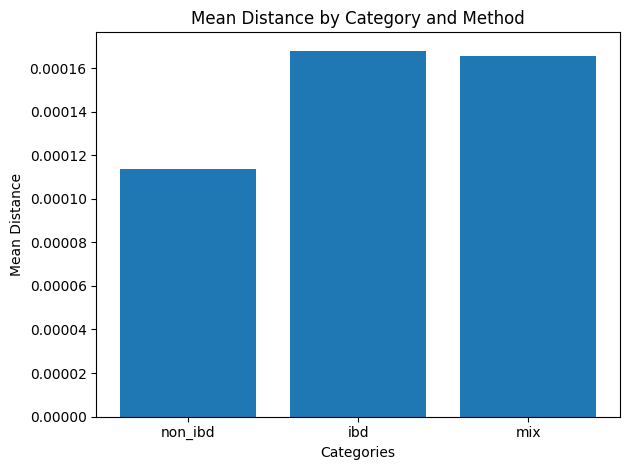

In [ ]:
import matplotlib.pyplot as plt

# Data for the bar plot
categories = ['non_ibd', 'ibd', 'mix']
met_means = [np.mean(non_ibdMET), np.mean(ibdMET), np.mean(mixMET)]
unifrac_means = [np.mean(non_ibdUniFrac), np.mean(ibdUniFrac), np.mean(mixUniFrac)]
print(unifrac_means)
# Plotting the bar plot
# x = np.arange(len(categories))  # the label locations
# width = 0.35  # the width of the bars

fig, ax = plt.subplots()
ax.bar(categories, unifrac_means)
# rects1 = ax.bar(x - width/2, met_means, width, label='MET')
# rects2 = ax.bar(x + width/2, unifrac_means, width, label='UniFrac')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Categories')
ax.set_ylabel('Mean Distance')
ax.set_title('Mean Distance by Category and Method')
# ax.set_xticks(x)
#ax.set_xticklabels(categories)
#ax.legend()

fig.tight_layout()

plt.show()


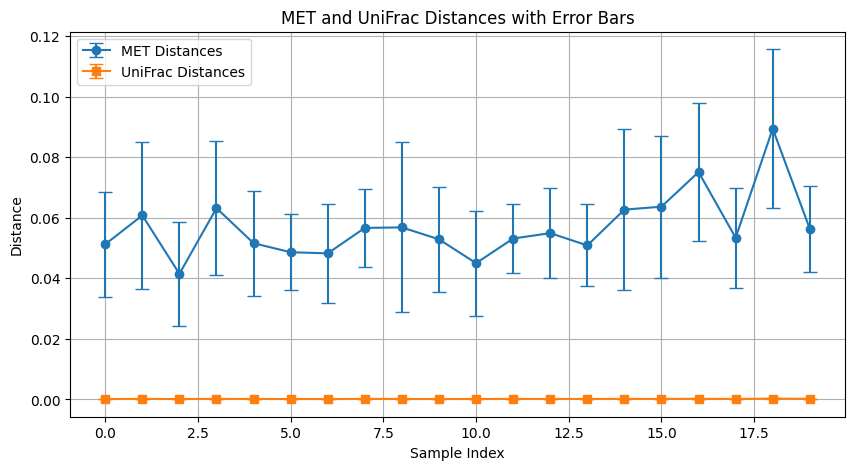

In [109]:
# Assuming MET_dists and UniFrac_dists are your distance matrices
MET_dists = np.load('MET_dists.npy')
UniFrac_dists = np.load('UniFrac_dists.npy')

# Calculate means and standard deviations for error bars
MET_means = np.mean(MET_dists, axis=0)
MET_stds = np.std(MET_dists, axis=0)
UniFrac_means = np.mean(UniFrac_dists, axis=0)
UniFrac_stds = np.std(UniFrac_dists, axis=0)

# Plotting with error bars
x = np.arange(len(MET_means))

plt.figure(figsize=(10, 5))

plt.errorbar(x, MET_means, yerr=MET_stds, fmt='-o', label='MET Distances', capsize=5)
plt.errorbar(x, UniFrac_means, yerr=UniFrac_stds, fmt='-s', label='UniFrac Distances', capsize=5)

plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.title('MET and UniFrac Distances with Error Bars')
plt.legend()
plt.grid(True)

plt.show()